# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [8]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [4]:
# Import essential libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation



In [5]:
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:",tf.__version__)
print("tensorflow keras:",tf.keras.__version__)

numpy: 2.1.3
pandas: 2.2.3
seaborn: 0.13.2
sklearn: 1.6.1
tensorflow: 2.19.0
tensorflow keras: 3.9.2


Load the dataset.

In [6]:
# Load and unzip the dataset
zip_path = 'data.zip'  # Update this with your actual filename

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()


In [7]:
data_dir = 'data'

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=1,
    shuffle=True
)

print("Classes found:", dataset.class_names)


Found 7625 files belonging to 7 classes.
Classes found: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [8]:
# Create a function to load the raw images

def load_and_crop_image(image_path, crop_size=(128, 128), resize_size=None):
    with Image.open(image_path) as img:
        width, height = img.size
        crop_width, crop_height = crop_size

        # Calculate cropping box (center crop)
        left = max((width - crop_width) // 2, 0)
        top = max((height - crop_height) // 2, 0)
        right = left + crop_width
        bottom = top + crop_height

        cropped_img = img.crop((left, top, right, bottom))

        if resize_size:
            cropped_img = cropped_img.resize(resize_size, Image.ANTIALIAS)

        return cropped_img



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [9]:
# Load image file paths and their corresponding labels

# Get class names from the subdirectories in data_dir
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

image_paths = []
labels = []

for label_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_name)

# Verify loading
print(f"Total images loaded: {len(image_paths)}")
print(f"Labels length: {len(labels)}")
print("Unique labels found:", set(labels))

Total images loaded: 7625
Labels length: 7625
Unique labels found: {'Other', 'Metal', 'Food_Waste', 'Plastic', 'Cardboard', 'Glass', 'Paper'}


In [10]:
# Get the images and their labels

# Print all image paths and their corresponding labels (showing only the first 10 for brevity)
for i in range(min(10, len(image_paths))):
    print(f"Image: {image_paths[i]}  |  Label: {labels[i]}")


Image: data\Cardboard\file_1.png  |  Label: Cardboard
Image: data\Cardboard\file_10.png  |  Label: Cardboard
Image: data\Cardboard\file_100.png  |  Label: Cardboard
Image: data\Cardboard\file_101.png  |  Label: Cardboard
Image: data\Cardboard\file_102.png  |  Label: Cardboard
Image: data\Cardboard\file_103.png  |  Label: Cardboard
Image: data\Cardboard\file_104.png  |  Label: Cardboard
Image: data\Cardboard\file_105.png  |  Label: Cardboard
Image: data\Cardboard\file_106.png  |  Label: Cardboard
Image: data\Cardboard\file_107.png  |  Label: Cardboard


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

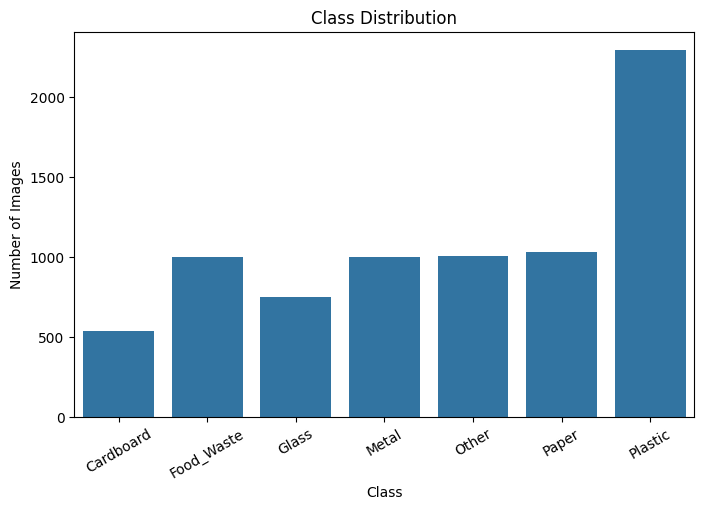

In [11]:
# Visualise Data Distribution

df_labels = pd.DataFrame({'label': labels})

plt.figure(figsize=(8, 5))
sns.countplot(data=df_labels, x='label', order=class_names)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=30)
plt.show()

In [12]:
# Print class distribution counts
df_labels = pd.DataFrame({'label': labels})
print(df_labels['label'].value_counts())

label
Plastic       2295
Paper         1030
Other         1010
Food_Waste    1000
Metal         1000
Glass          750
Cardboard      540
Name: count, dtype: int64


In [ ]:
# Above cell suggests class imbalance
# Plastic has 2295 images, much more than the other classes.
# Cardboard has only 540 images and Glass has 750.
# This suggests that the model may be biased towards the class with more images.
# Hence data augmentation is needed which is done in section 4.

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

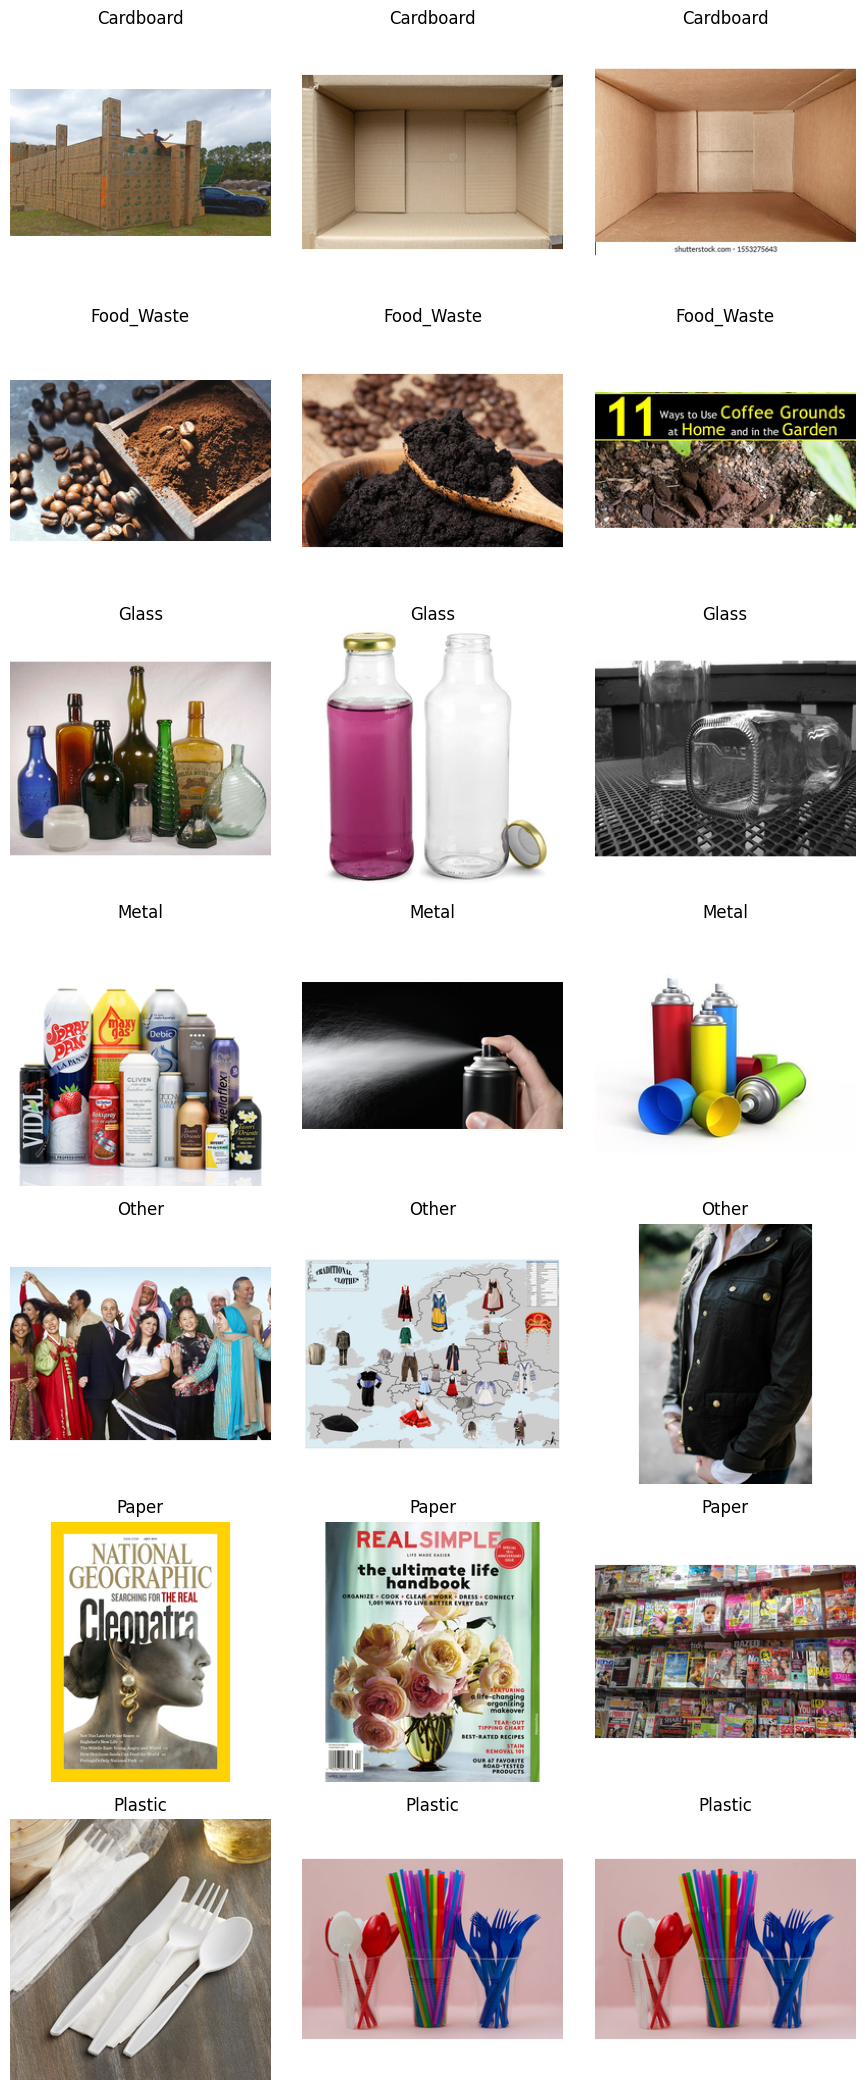

In [13]:
# Visualise Sample Images (across different labels)

img_width, img_height = 256, 256  # Set image dimensions

num_classes = len(class_names)
samples_per_class = 3  # Number of images to show per class

plt.figure(figsize=(samples_per_class * 3, num_classes * 3))

for row, class_name in enumerate(class_names):
    # Get indices of images belonging to the current class
    class_indices = [i for i, label in enumerate(labels) if label == class_name]
    for col in range(samples_per_class):
        idx = class_indices[col % len(class_indices)]
        img = load_and_crop_image(image_paths[idx], crop_size=(img_width, img_height))
        plt.subplot(num_classes, samples_per_class, row * samples_per_class + col + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [14]:
# Find the smallest and largest image dimensions from the data set
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

for path in image_paths:
    with Image.open(path) as img:
        width, height = img.size
        if width < min_width:
            min_width = width
        if height < min_height:
            min_height = height
        if width > max_width:
            max_width = width
        if height > max_height:
            max_height = height

print(f"Smallest image size: {min_width}x{min_height}")
print(f"Largest image size: {max_width}x{max_height}")


Smallest image size: 256x256
Largest image size: 256x256


In [ ]:
# Resize the image dimensions

# Since the images are of same size 256 X 256 , we do not need to resize them.

# But if you want to resize them to a different size, you can use the following code:
# Resize all images to (min_width, min_height) and overwrite them.

# for path in image_paths:
#     img = load_and_crop_image(path, crop_size=(min_width, min_height), resize_size=(min_width, min_height))
#     img.save(path)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [15]:
# Encode the labels suitably
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
one_hot_encoded_labels = to_categorical(integer_encoded)

print("Total Labels:\n", label_encoder.classes_)
print("Shape of integer_encoded:\n", integer_encoded.shape)
print("one_hot_encoded_labels:\n", one_hot_encoded_labels)
print("Shape of one_hot_encoded_labels:\n", one_hot_encoded_labels.shape)

Total Labels:
 ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Shape of integer_encoded:
 (7625,)
one_hot_encoded_labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Shape of one_hot_encoded_labels:
 (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [16]:
# Assign specified parts of the dataset to train and validation sets

# 80% of the data for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    image_paths,
    one_hot_encoded_labels,
    test_size=0.2,
    stratify=one_hot_encoded_labels,
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_val)}")


Training samples: 6100
Test samples: 1525


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [17]:
# Build and compile the model

from keras.regularizers import l2

def build_model(input_shape, num_classes):
    model = Sequential()
    # Convolutional layer1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Convolutional layer2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Convolutional layer3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [27]:
# Training

# Convert the image paths to numpy arrays
X_train_arr = np.array([np.array(load_and_crop_image(path, crop_size=(img_height, img_width))) / 255.0 for path in X_train])
X_val_arr = np.array([np.array(load_and_crop_image(path, crop_size=(img_height, img_width))) / 255.0 for path in X_val])

input_shape = X_train_arr.shape[1:]  # (height, width, channels)
model1 = build_model(input_shape, num_classes)

history1 = model1.fit(
    X_train_arr, y_train,
    validation_data=(X_val_arr, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.2859 - loss: 2.4104 - val_accuracy: 0.2623 - val_loss: 2.2006 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.4428 - loss: 1.6661 - val_accuracy: 0.3102 - val_loss: 2.3310 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.4878 - loss: 1.4514 - val_accuracy: 0.4446 - val_loss: 1.5632 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.5717 - loss: 1.2000 - val_accuracy: 0.3410 - val_loss: 2.8182 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.6182 - loss: 1.0769 - val_accuracy: 0.4984 - val_loss: 1.5040 - learning_rate: 0.0010
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.7206 - loss: 0.8176 - val_accuracy: 0.5823 - val_loss: 1.2648 - learning_rate: 0.0010
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7843 - loss: 0.

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.58      0.80      0.67       108
  Food_Waste       0.50      0.74      0.60       200
       Glass       0.63      0.27      0.38       150
       Metal       0.70      0.49      0.58       200
       Other       0.65      0.27      0.38       202
       Paper       0.52      0.59      0.55       206
     Plastic       0.61      0.74      0.67       459

    accuracy                           0.58      1525
   macro avg       0.60      0.56      0.55      1525
weighted avg       0.60      0.58      0.56      1525



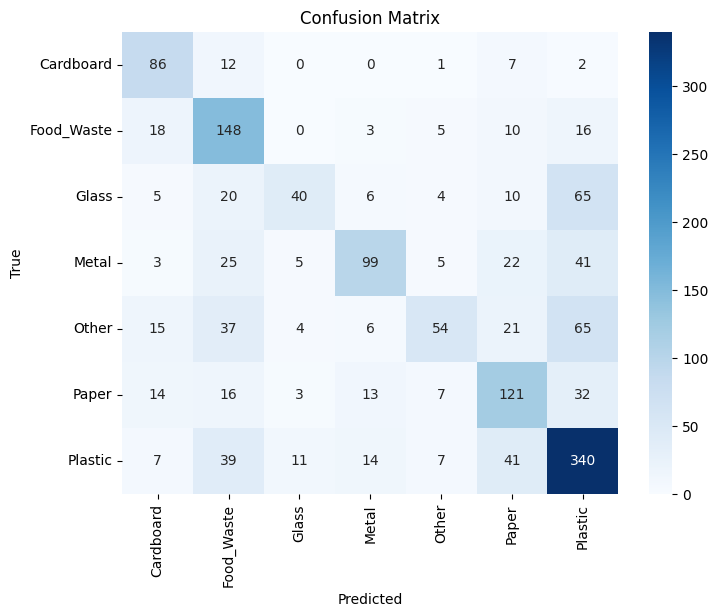

In [29]:
# Evaluate on the test set; display suitable metrics

# Prepare test images as numpy array
X_val_arr = np.array([np.array(load_and_crop_image(path, crop_size=(img_height, img_width))) / 255.0 for path in X_val])

# Predict classes
y_pred_probs = model1.predict(X_val_arr)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Conclusion

# Model Training Summary
# Number of Epochs: 10
# Final Training Accuracy: 95.43%
# Final Training Loss: 0.1568

# Model Testing Performance
# Test Accuracy: 58%
# The training accuracy (95%) is much higher than the test accuracy (58%), suggesting overfitting — the model performs well on training data but does not generalize well to unseen images.
# Cardboard, Food_Waste, and Plastic achieved the best recall, meaning the model is good at correctly identifying those categories.
# Glass and Other classes showed low recall, suggesting the model struggles to detect them, likely due to high visual variability or class imbalance.

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [69]:
# Define augmentation steps to augment images

# Step 1 :  Create a function to augment the images. This may involve randomly rotating, translating, flipping or zooming the images.
# Step 2 :  Create the augmented training dataset. 
# Step 3 :  Create the augmented validation dataset.


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [18]:
# Create a function to augment the images
import pandas as pd
train_df = pd.DataFrame({
    'filename': X_train,
    'class': [label_encoder.inverse_transform([np.argmax(y)])[0] for y in y_train]
})

val_df = pd.DataFrame({
    'filename': X_val,
    'class': [label_encoder.inverse_transform([np.argmax(y)])[0] for y in y_val]
})

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



Found 6100 validated image filenames belonging to 7 classes.
Found 1525 validated image filenames belonging to 7 classes.


In [20]:
# Create the augmented training dataset
input_shape = (img_height, img_width, 3)
augmented_model = build_model(input_shape, num_classes)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)

class_weights = dict(enumerate(class_weights))

##### **4.1.2**

Train the model on the new augmented dataset.

In [22]:
# Train the model using augmented images

augmented_history = augmented_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)



c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.2123 - loss: 2.5652 - val_accuracy: 0.1193 - val_loss: 3.5533 - learning_rate: 0.0010
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.2848 - loss: 1.9465 - val_accuracy: 0.2689 - val_loss: 1.8423 - learning_rate: 0.0010
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - accuracy: 0.3464 - loss: 1.7462 - val_accuracy: 0.2990 - val_loss: 1.7456 - learning_rate: 0.0010
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.3509 - loss: 1.6337 - val_accuracy: 0.3626 - val_loss: 1.6285 - learning_rate: 0.0010
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.3950 - loss: 1.5677 - val_accuracy: 0.2780 - val_loss: 1.9098 - learning_rate: 0.0010
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 449s 2s/step - accuracy: 0.3987 - loss: 1.5349 - val_accuracy: 0.4177 - val_loss: 1.4880 - learning_rate: 0.0010
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.4466 - loss: 1.

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step
Classification Report of Augmented model:
              precision    recall  f1-score   support

   Cardboard       0.63      0.84      0.72       108
  Food_Waste       0.68      0.70      0.69       200
       Glass       0.56      0.63      0.59       150
       Metal       0.63      0.78      0.70       200
       Other       0.49      0.39      0.43       202
       Paper       0.41      0.60      0.48       206
     Plastic       0.79      0.51      0.62       459

    accuracy                           0.60      1525
   macro avg       0.60      0.64      0.61      1525
weighted avg       0.63      0.60      0.60      1525



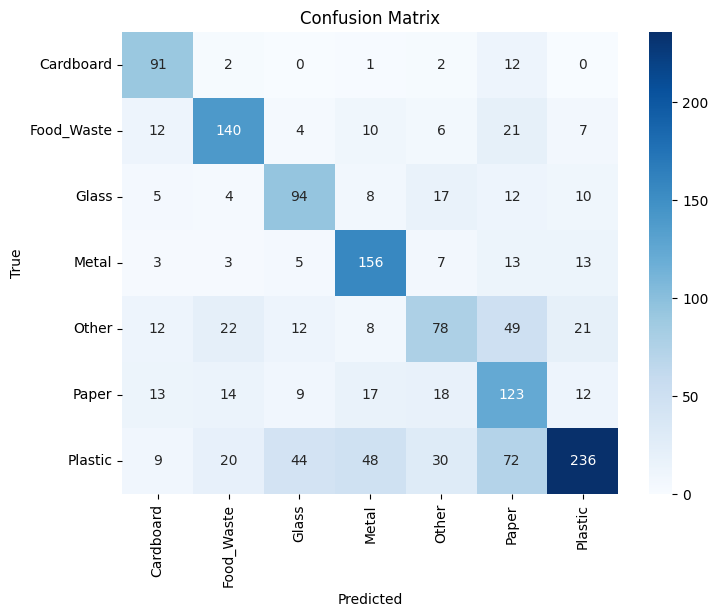

In [26]:
# Testing the augmented model
X_val_arr = np.array([np.array(load_and_crop_image(path, crop_size=(img_height, img_width))) / 255.0 for path in X_val])

# Predict classes
y_pred_probs_aug = augmented_model.predict(X_val_arr)
y_pred_aug = np.argmax(y_pred_probs_aug, axis=1)
y_true_aug = np.argmax(y_val, axis=1)

# Classification report
print("Classification Report of Augmented model:")
print(classification_report(y_true_aug, y_pred_aug, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true_aug, y_pred_aug)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

In [ ]:
# Without Data augmentation

# Model Training Summary
# Number of Epochs: 10
# Final Training Accuracy: 95.43%
# Final Training Loss: 0.1568

# Model Testing Performance
# Test Accuracy: 58%
# The training accuracy (95%) is much higher than the test accuracy (58%), suggesting overfitting — the model performs well on training data but does not generalize well to unseen images.
# Cardboard, Food_Waste, and Plastic achieved the best recall, meaning the model is good at correctly identifying those categories.
# Glass and Other classes showed low recall, suggesting the model struggles to detect them, likely due to high visual variability or class imbalance.

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Data augmentation has improved the model's performance.

# Model Training Summary
# Training Accuracy: 60.68%
# Training Loss: 1.0181
# Compared to the previous (overfitted) model with 95% training accuracy, this model has more realistic performance, indicating improved generalization.

# Model Testing Performance
# Test Accuracy: 60%
# Data augmentation successfully improved generalization — the test accuracy is now closely aligned with the training accuracy (60% vs 60.68%).
# Cardboard, Food_Waste, Metal, and Glass now show significant improvement in both precision and recall.
# Plastic has high precision but lower recall, indicating many false negatives (missed plastic items).
# "Other" and "Paper" remain challenging due to possibly high visual variability or class imbalance.

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Summary of the model performance before and after augmentation
# -----------------------------------------------------------------------------
# Metric	         |   Before Augmentation	|    After Augmentation
# -----------------------------------------------------------------------------
# Training Accuracy	 |   95.4%	                |    60.7%
# Test Accuracy	     |   58%	                |    60% 
# Overfitting	     |   High	                |    Reduced 
# Generalization	 |   Poor	                |    Improved 
